imports

In [1]:
import matplotlib.pyplot as plt
import torch
import sys
import os
from sklearn.metrics import f1_score
from tqdm.notebook import tqdm as tqdm
from tqdm.auto import trange
import numpy as np

import warnings
warnings.filterwarnings("ignore")

from myhelpers import config_plots, TrialStatistics
from HGNN.train import CNN, dataLoader
from HGNN.train.configParser import ConfigParser, getModelName, getDatasetName
config_plots.global_settings()

parameters

In [2]:
experimentsPath="/raid/elhamod/Fish/experiments/"
dataPath="/raid/elhamod/Fish"
# experimentName="biology_paper_curated4_Easy50_tryphylogeny_2"
# experimentName="biology_paper_easy_curated4_Easy_smaller"
experimentName="biology_paper_easy_curated4_Medium"

generate_confusion_matrix = False

cuda=1

Cuda

In [3]:
# set cuda
if torch.cuda.is_available():
    torch.cuda.set_device(cuda)
    print("using cuda", cuda)

using cuda 1


Setup

In [4]:
config_parser = ConfigParser(experimentsPath, dataPath, experimentName)

experimentPathAndName = os.path.join(experimentsPath, experimentName)

# instantiate trial stat object
results_dir = os.path.join(experimentPathAndName, "results")
ts = TrialStatistics.TrialStatistics(results_dir)
ts_coarse = TrialStatistics.TrialStatistics(results_dir, "coarse")

datasetManager = dataLoader.datasetManager(experimentPathAndName, dataPath)

paramsIterator = config_parser.getExperiments()  
number_of_experiments = sum(1 for e in paramsIterator)  

Show and save trial statistics

In [5]:

with tqdm(total=number_of_experiments, desc="experiment") as bar:
    for experiment_params in config_parser.getExperiments():
        print(experiment_params)

        # For analyzing experiments, we don't care about augmentation
        datasetManager.updateParams(config_parser.fixPaths({**experiment_params,**{'augmented': False}}))
        train_loader, validation_loader, test_loader = datasetManager.getLoaders()
        fineList = train_loader.dataset.csv_processor.getFineList()
        coarseList = train_loader.dataset.csv_processor.getCoarseList()
        architecture = {
            "fine": len(fineList),
            "coarse" : len(coarseList)
        }


        
        # Loop through n trials
        for i in trange(experiment_params["numOfTrials"], desc="trial"):
            modelName = getModelName(experiment_params, i)
            trialName = os.path.join(experimentPathAndName, modelName)
            
            # Train/Load model
            print(CNN.getModelFile(trialName))
            model = CNN.create_model(architecture, experiment_params, device=cuda)
            if os.path.exists(CNN.getModelFile(trialName)):
                df, epochs, time_elapsed = CNN.loadModel(model, trialName, device=cuda)
                
                # Update trial outcomes for statistics
                predlist, lbllist = CNN.getLoaderPredictionProbabilities(test_loader, model, experiment_params, device=cuda)
                loss = CNN.getCrossEntropy(predlist, lbllist)
                avg_prob = CNN.getAvgProbCorrectGuess(predlist, lbllist)
                topk = CNN.top_k_acc(predlist, lbllist, topk=(3,5))
                
                predlist, lbllist = CNN.getPredictions(predlist, lbllist)
                labels =list(map(lambda x: x[1] + " - " + str(x[0]), enumerate(fineList))) 
                ts.addTrialPredictions(experiment_params,i, predlist, lbllist, labels)
                micro_f1 = f1_score(lbllist.cpu(), predlist.cpu(), average='macro')

                predlist, lbllist = CNN.getLoaderPredictionProbabilities(test_loader, model, experiment_params, 'coarse', device=cuda)
                predlist, lbllist = CNN.getPredictions(predlist, lbllist)
                labels =list(map(lambda x: x[1] + " - " + str(x[0]), enumerate(coarseList)))
                ts_coarse.addTrialPredictions(experiment_params,i, predlist, lbllist, labels)
                micro_f1_coarse = f1_score(lbllist.cpu(), predlist.cpu(), average='macro')

                predlist, lbllist = CNN.getLoaderPredictionProbabilities(validation_loader, model, experiment_params, device=cuda)
                predlist, lbllist = CNN.getPredictions(predlist, lbllist)
                macro_f1_val = f1_score(lbllist.cpu(), predlist.cpu(), average='macro')

                score = {'loss': loss,
                         'average correct guess prob': avg_prob,
                         'macro f1 test fine': micro_f1,
                         'macro f1 test coarse': micro_f1_coarse,
                         'macro f1 validation fine': macro_f1_val,
                         'time': time_elapsed,
                         'epochs': epochs,
                         'top-3': topk[0].cpu().numpy(),
                         'top-5': topk[1].cpu().numpy(),
                        }

                ts.addTrial(experiment_params,
                    score, i)
            else:
                print("Model {0} not found!".format(trialName))
        
        bar.update()

{'image_path': 'Curated4/Medium', 'suffix': 'curated_30_50', 'img_res': 448, 'augmented': True, 'batchSize': 64, 'learning_rate': 0.0001, 'numOfTrials': 5, 'fc_layers': 1, 'modelType': 'HGNN_add', 'lambda': 0.01, 'unsupervisedOnTest': False, 'tl_model': 'ResNet18', 'link_layer': 'avgpool', 'adaptive_smoothing': True, 'adaptive_lambda': 0.01, 'adaptive_alpha': 0.9, 'noSpeciesBackprop': False, 'phylogeny_loss': False, 'phylogeny_loss_epsilon': 0.03}
Creating datasets...
Creating datasets... Done.
Creating loaders...
Creating loaders... Done.


/raid/elhamod/Fish/experiments/biology_paper_easy_curated4_Medium/models/d6b728c67cf15c261122c534ee142dbccfce95a394b4679303b9cfb9/finalModel.pt
Saving  /raid/elhamod/Fish/experiments/biology_paper_easy_curated4_Medium/results/d02451d2393fdbaa09031451d55942faf5fabde7e11df5b89dd52c9e/trial_confusion_matrix_d6b728c67cf15c261122c534ee142dbccfce95a394b4679303b9cfb9.csv
Saving  /raid/elhamod/Fish/experiments/biology_paper_easy_curated4_Medium/results/d02451d2393fdbaa09031451d55942faf5fabde7e11df5b89dd52c9e/coarse_trial_confusion_matrix_d6b728c67cf15c261122c534ee142dbccfce95a394b4679303b9cfb9.csv
/raid/elhamod/Fish/experiments/biology_paper_easy_curated4_Medium/models/79bcc4112384531e0147cc1f83992ae21f01f11ce914df9cfb03d053/finalModel.pt
Saving  /raid/elhamod/Fish/experiments/biology_paper_easy_curated4_Medium/results/d02451d2393fdbaa09031451d55942faf5fabde7e11df5b89dd52c9e/trial_confusion_matrix_79bcc4112384531e0147cc1f83992ae21f01f11ce914df9cfb03d053.csv
Saving  /raid/elhamod/Fish/experimen

/raid/elhamod/Fish/experiments/biology_paper_easy_curated4_Medium/models/7af075f42b4a4e0d5746b064c4f67112c2b4930be1fe6d1fa817d629/finalModel.pt
Saving  /raid/elhamod/Fish/experiments/biology_paper_easy_curated4_Medium/results/81ba7f96e6a39fece451b53d234c43c77199398b0f10f423121d66b4/trial_confusion_matrix_7af075f42b4a4e0d5746b064c4f67112c2b4930be1fe6d1fa817d629.csv
Saving  /raid/elhamod/Fish/experiments/biology_paper_easy_curated4_Medium/results/81ba7f96e6a39fece451b53d234c43c77199398b0f10f423121d66b4/coarse_trial_confusion_matrix_7af075f42b4a4e0d5746b064c4f67112c2b4930be1fe6d1fa817d629.csv
/raid/elhamod/Fish/experiments/biology_paper_easy_curated4_Medium/models/a547a007ad97adc3ae61fbc2131211a41888c33e87cdab6a3d679453/finalModel.pt
Saving  /raid/elhamod/Fish/experiments/biology_paper_easy_curated4_Medium/results/81ba7f96e6a39fece451b53d234c43c77199398b0f10f423121d66b4/trial_confusion_matrix_a547a007ad97adc3ae61fbc2131211a41888c33e87cdab6a3d679453.csv
Saving  /raid/elhamod/Fish/experimen

/raid/elhamod/Fish/experiments/biology_paper_easy_curated4_Medium/models/05e7e7e8f6618fcf928dd945cfb46a5d91769a0a1214a7c06ea916f4/finalModel.pt
Saving  /raid/elhamod/Fish/experiments/biology_paper_easy_curated4_Medium/results/d384d76693425e9b3890ebde63703cb09354086bd3050b9565abc209/trial_confusion_matrix_05e7e7e8f6618fcf928dd945cfb46a5d91769a0a1214a7c06ea916f4.csv
Saving  /raid/elhamod/Fish/experiments/biology_paper_easy_curated4_Medium/results/d384d76693425e9b3890ebde63703cb09354086bd3050b9565abc209/coarse_trial_confusion_matrix_05e7e7e8f6618fcf928dd945cfb46a5d91769a0a1214a7c06ea916f4.csv
/raid/elhamod/Fish/experiments/biology_paper_easy_curated4_Medium/models/cfaaca319511aca663f80ed02d55af8493189b82f764b4c7dde5207b/finalModel.pt
Saving  /raid/elhamod/Fish/experiments/biology_paper_easy_curated4_Medium/results/d384d76693425e9b3890ebde63703cb09354086bd3050b9565abc209/trial_confusion_matrix_cfaaca319511aca663f80ed02d55af8493189b82f764b4c7dde5207b.csv
Saving  /raid/elhamod/Fish/experimen

In [6]:
# Save experiment results
ts.saveStatistics()
ts.showStatistics()

In [7]:
# ts.df.replace('/','', regex=True).replace('_','', regex=True).groupby(['modelType']).mean()

In [8]:
ts.saveStatistics(False)
ts.showStatistics(False)

,image_path,suffix,img_res,augmented,batchSize,learning_rate,numOfTrials,fc_layers,modelType,lambda,unsupervisedOnTest,tl_model,link_layer,adaptive_smoothing,adaptive_lambda,adaptive_alpha,noSpeciesBackprop,phylogeny_loss,phylogeny_loss_epsilon,loss,average correct guess prob,macro f1 test fine,macro f1 test coarse,macro f1 validation fine,time,epochs,top-3,top-5,experimentHash,trial,trialHash
0,Curated4/Medium,curated_30_50,448,True,64,0.0001,5,1,HGNN_add,0.01,False,ResNet18,avgpool,True,0.01,0.9,False,False,0.03,4.088941,0.548886,0.791798,0.831618,0.785908,10067.837873,43.0,91.908714,93.672203,d02451d2393fdbaa09031451d55942faf5fabde7e11df5b89dd52c9e,0,d6b728c67cf15c261122c534ee142dbccfce95a394b4679303b9cfb9
1,Curated4/Medium,curated_30_50,448,True,64,0.0001,5,1,HGNN_add,0.01,False,ResNet18,avgpool,True,0.01,0.9,False,False,0.03,4.075023,0.562886,0.805718,0.862167,0.785432,11247.326665,48.0,92.323654,94.294609,d02451d2393fdbaa09031451d55942faf5fabde7e11df5b89dd52c9e,1,79bcc4112384531e0147cc1f83992ae21f01f11ce914df9cfb03d053
2,Curated4/Medium,curated_30_50,448,True,64,0.0001,5,1,HGNN_add,0.01,False,ResNet18,avgpool,True,0.01,0.9,False,False,0.03,4.089332,0.548400,0.807645,0.822711,0.774023,9640.570944,41.0,92.323654,94.709541,d02451d2393fdbaa09031451d55942faf5fabde7e11df5b89dd52c9e,2,4b3adc6ba20cf82bfb32598cbbc9b38a949b2a091c2f30695d37a643
3,Curated4/Medium,curated_30_50,448,True,64,0.0001,5,1,HGNN_add,0.01,False,ResNet18,avgpool,True,0.01,0.9,False,False,0.03,4.082216,0.555531,0.796460,0.841695,0.777996,7288.963918,31.0,91.597511,93.361000,d02451d2393fdbaa09031451d55942faf5fabde7e11df5b89dd52c9e,3,1d127f74e8e87278926fe6b36911aac034defcaef290dba3af8cf34a
4,Curated4/Medium,curated_30_50,448,True,64,0.0001,5,1,HGNN_add,0.01,False,ResNet18,avgpool,True,0.01,0.9,False,False,0.03,4.082131,0.555699,0.799215,0.889284,0.784860,13939.373428,60.0,92.116180,94.813278,d02451d2393fdbaa09031451d55942faf5fabde7e11df5b89dd52c9e,4,d4584f3bba4573142682f1ff9d570e848a5b637391e4e1e6be606330
5,Curated4/Medium,curated_30_50,448,True,64,0.0001,5,1,BB,0.01,False,ResNet18,avgpool,True,0.01,0.9,False,False,0.03,4.080575,0.557324,0.793528,0.428191,0.773666,14007.912337,62.0,91.182571,93.568466,81ba7f96e6a39fece451b53d234c43c77199398b0f10f423121d66b4,0,7af075f42b4a4e0d5746b064c4f67112c2b4930be1fe6d1fa817d629
6,Curated4/Medium,curated_30_50,448,True,64,0.0001,5,1,BB,0.01,False,ResNet18,avgpool,True,0.01,0.9,False,False,0.03,4.082522,0.555336,0.795717,0.664193,0.772231,13577.068654,60.0,92.531120,93.568466,81ba7f96e6a39fece451b53d234c43c77199398b0f10f423121d66b4,1,a547a007ad97adc3ae61fbc2131211a41888c33e87cdab6a3d679453
7,Curated4/Medium,curated_30_50,448,True,64,0.0001,5,1,BB,0.01,False,ResNet18,avgpool,True,0.01,0.9,False,False,0.03,4.097168,0.540539,0.771129,0.508782,0.784039,9538.856757,42.0,90.560165,93.153526,81ba7f96e6a39fece451b53d234c43c77199398b0f10f423121d66b4,2,ea3decc0cd7966e20071b7d4dbe18c0127b87349176820a695872f85
8,Curated4/Medium,curated_30_50,448,True,64,0.0001,5,1,BB,0.01,False,ResNet18,avgpool,True,0.01,0.9,False,False,0.03,4.064232,0.573743,0.815672,0.717875,0.787551,17400.565676,77.0,93.568466,94.605812,81ba7f96e6a39fece451b53d234c43c77199398b0f10f423121d66b4,3,686b67a38223f6e800a02d91caccd709a10ff32cba74b5da84960549
9,Curated4/Medium,curated_30_50,448,True,64,0.0001,5,1,BB,0.01,False,ResNet18,avgpool,True,0.01,0.9,False,False,0.03,4.100450,0.537242,0.782036,0.499086,0.773501,9626.495421,43.0,91.078842,93.361000,81ba7f96e6a39fece451b53d234c43c77199398b0f10f423121d66b4,4,f3d5cec14b00462b24774a6745aa611879bb3df6858a56e121495f44


Show and save confusion matrix

In [9]:
if generate_confusion_matrix:
    with tqdm(total=number_of_experiments, desc="experiment") as bar:
        for experiment_params in config_parser.getExperiments():
            print(experiment_params)

            ts.printTrialConfusionMatrix(experiment_params, fineList , printOutput=True)
            ts_coarse.printTrialConfusionMatrix(experiment_params,  coarseList, printOutput=True)
            
            datasetManager.updateParams(config_parser.fixPaths({**experiment_params,**{'augmented': False}}))
            train_loader, validation_loader, test_loader = datasetManager.getLoaders()
            ts.printF1table(experiment_params, test_loader.dataset)

            bar.update()

findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


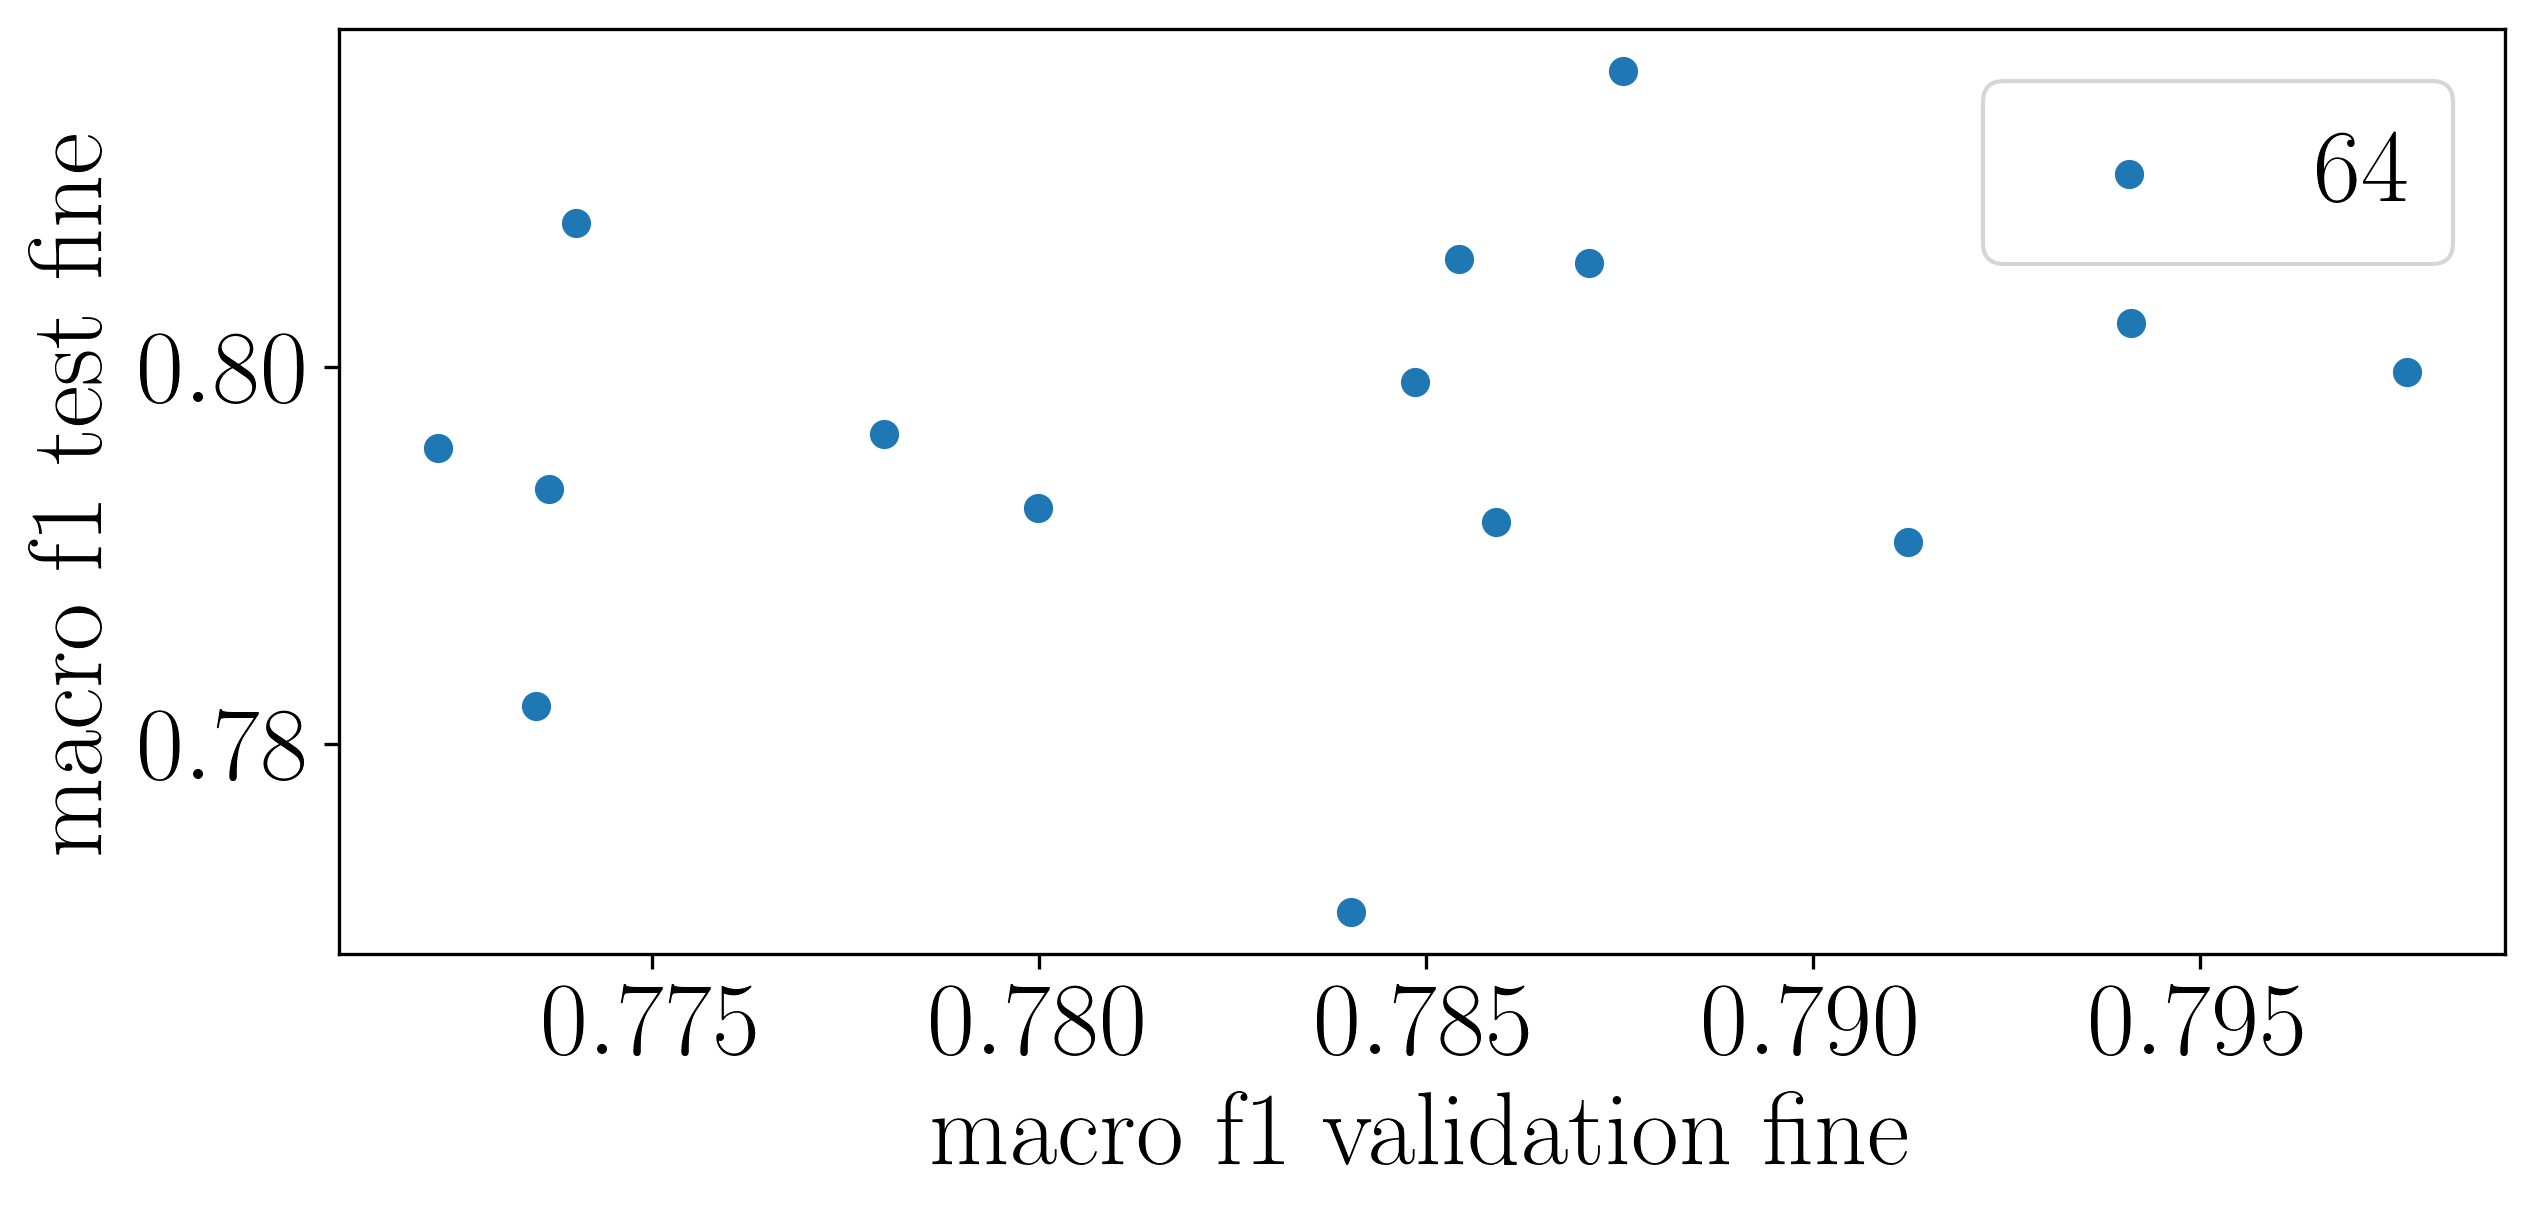

In [10]:
ts.df = ts.df.copy().replace(r"_", "", regex=True)
ts.df.columns = ts.df.columns.str.replace('_','')
ts.trialScatter('macro f1 validation fine', 'macro f1 test fine', aggregatedBy='batchSize', save_plot=True)

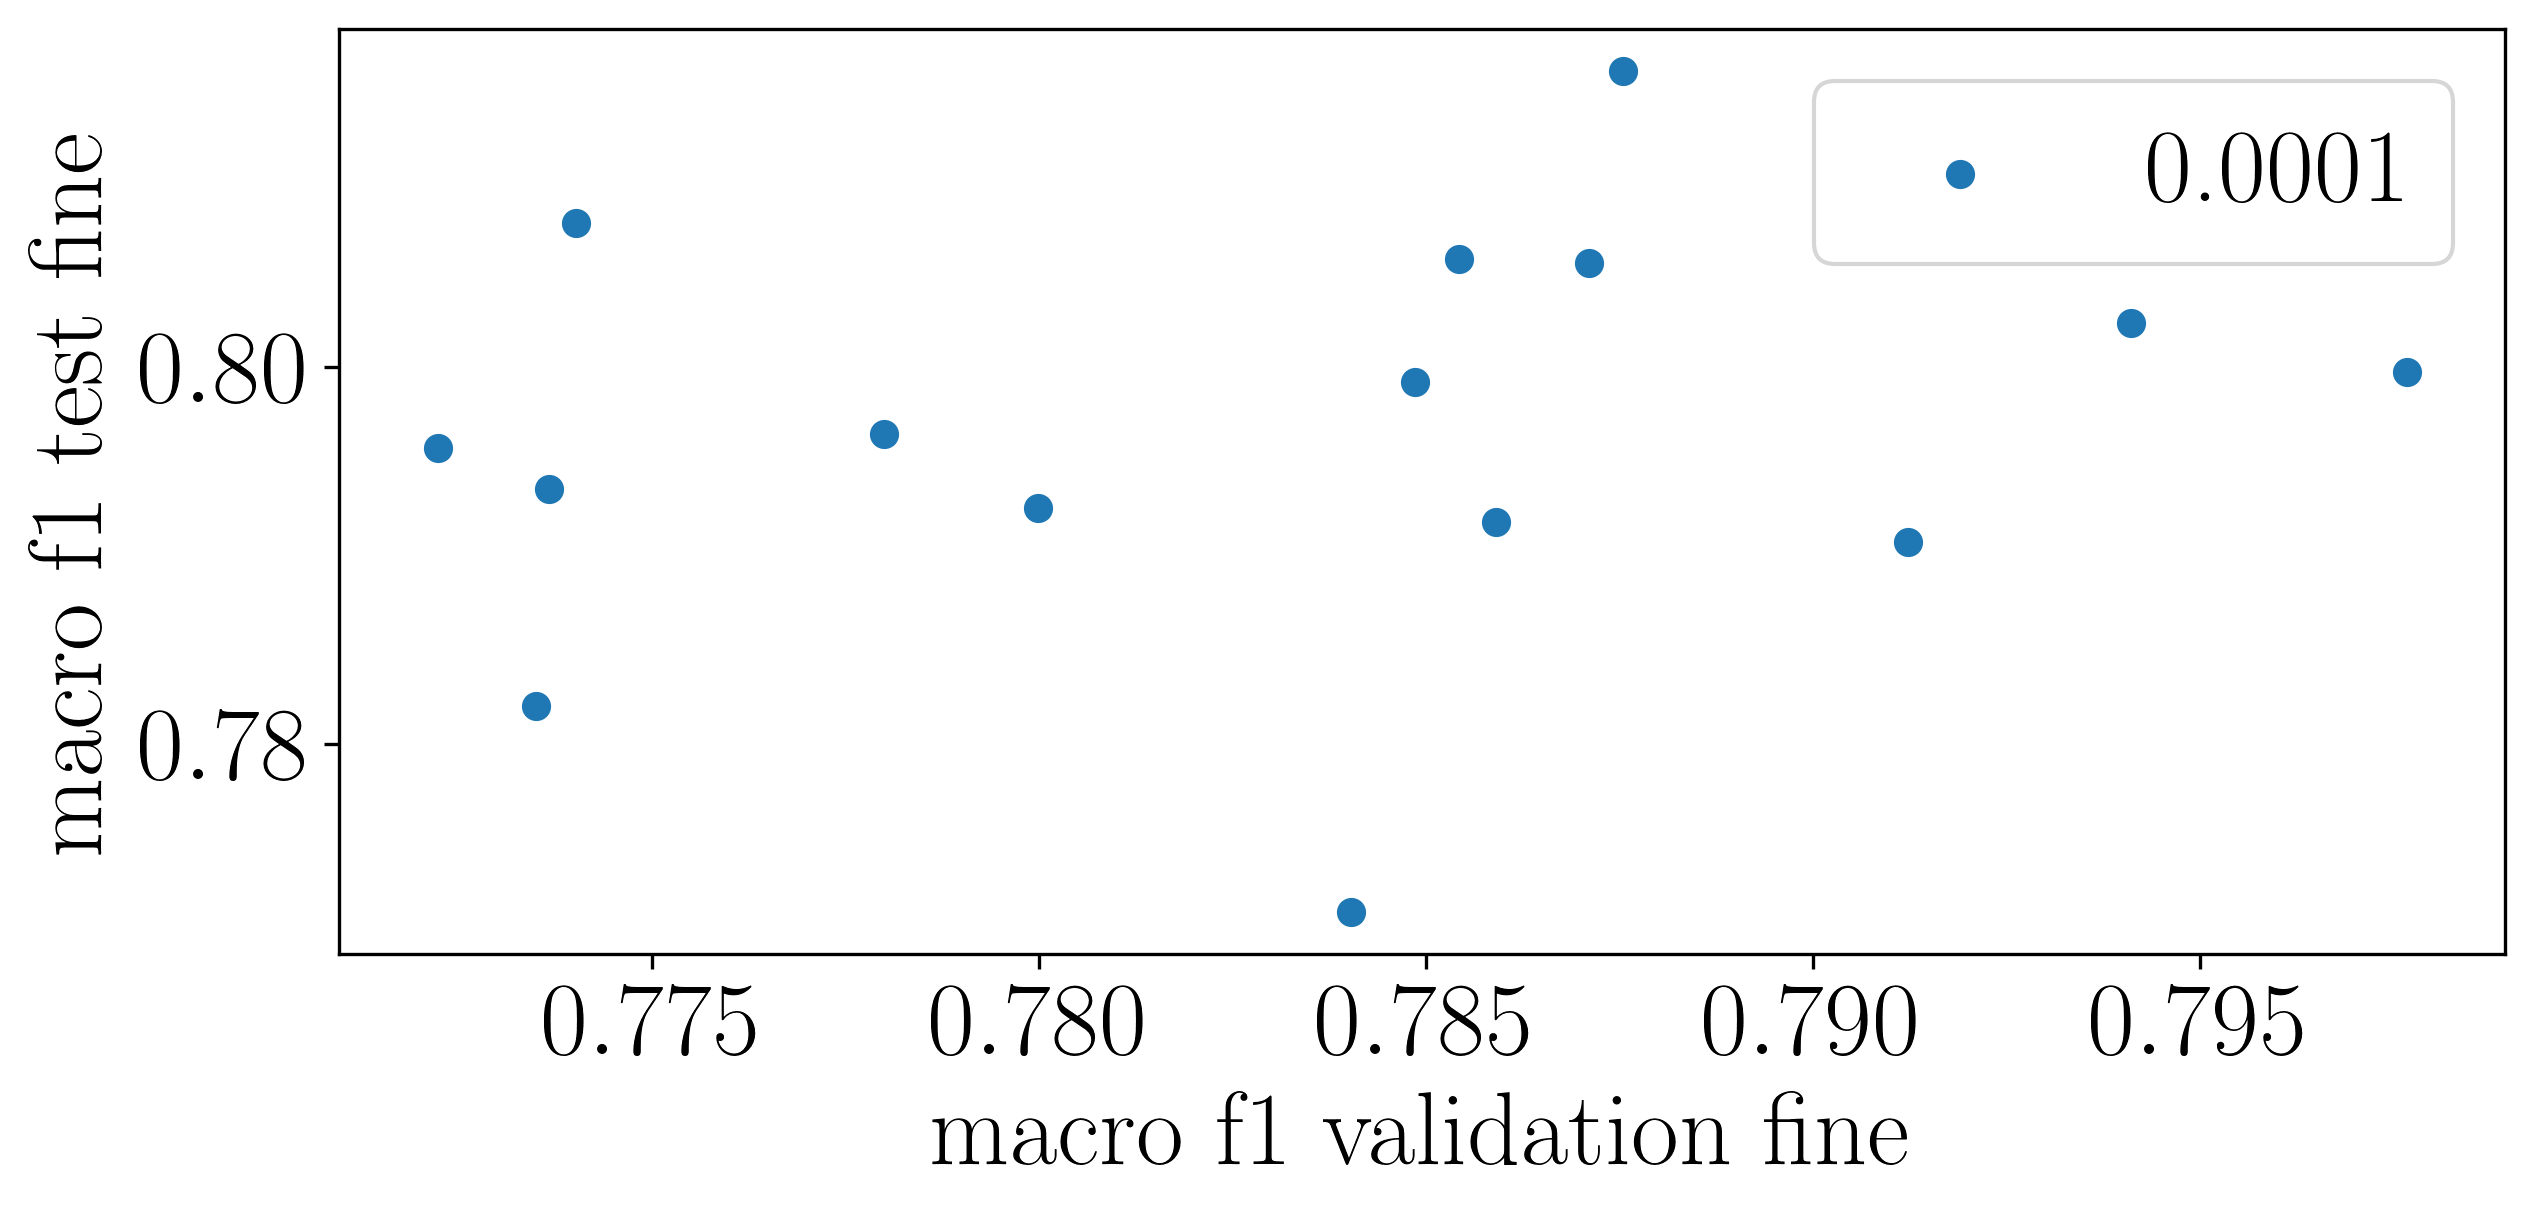

In [11]:
ts.trialScatter('macro f1 validation fine', 'macro f1 test fine', aggregatedBy='learningrate', save_plot=True)

Print scatter plot

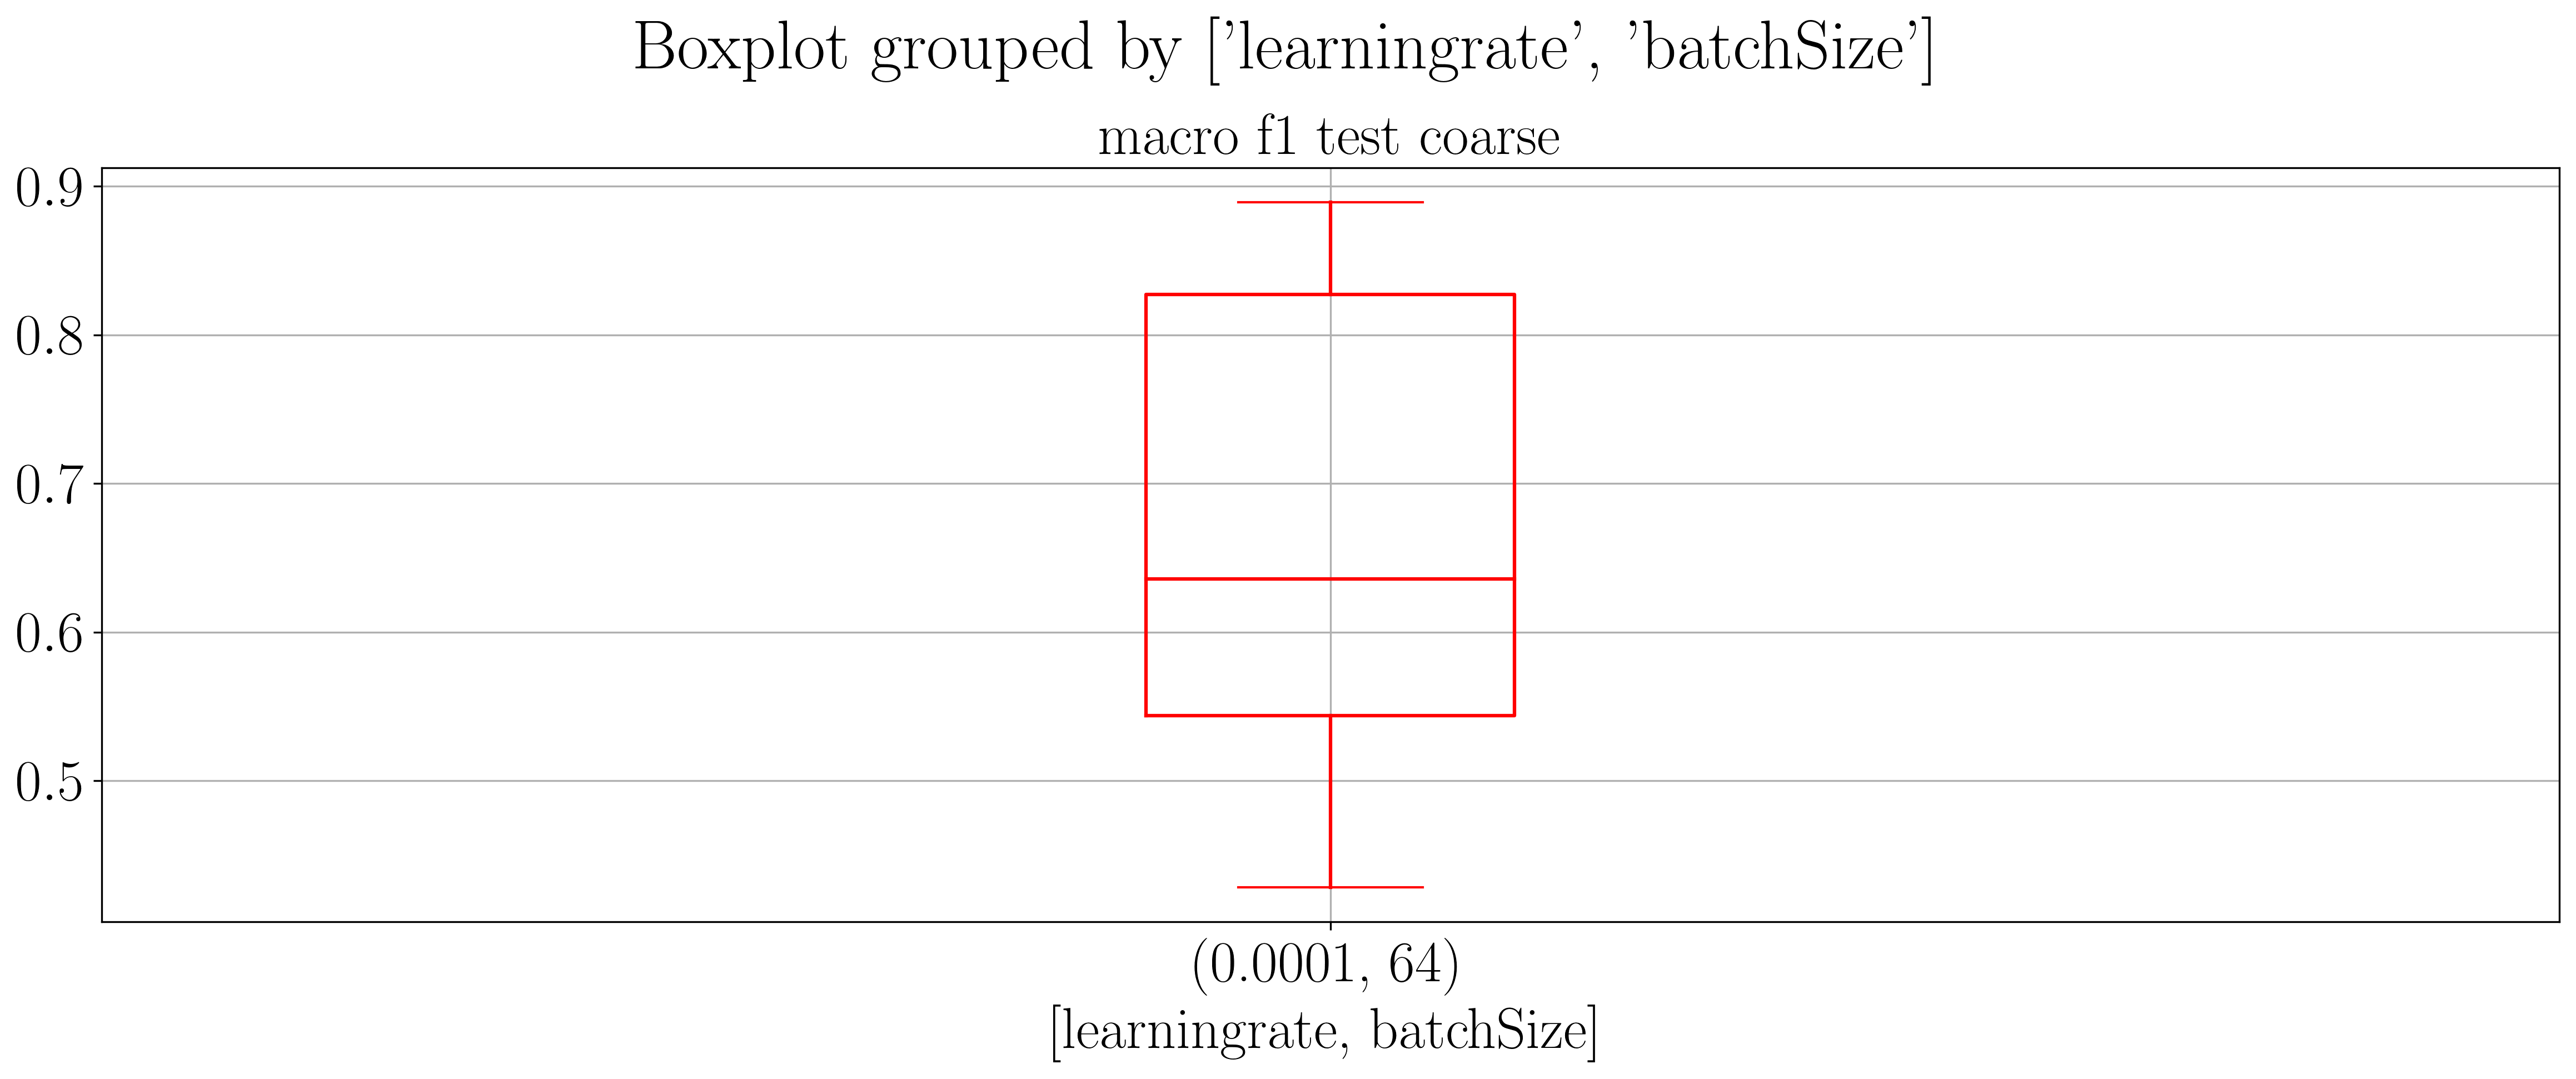

In [12]:
ts.pandasBoxplot(['macro f1 test coarse'], ['learning_rate', 'batchSize'])

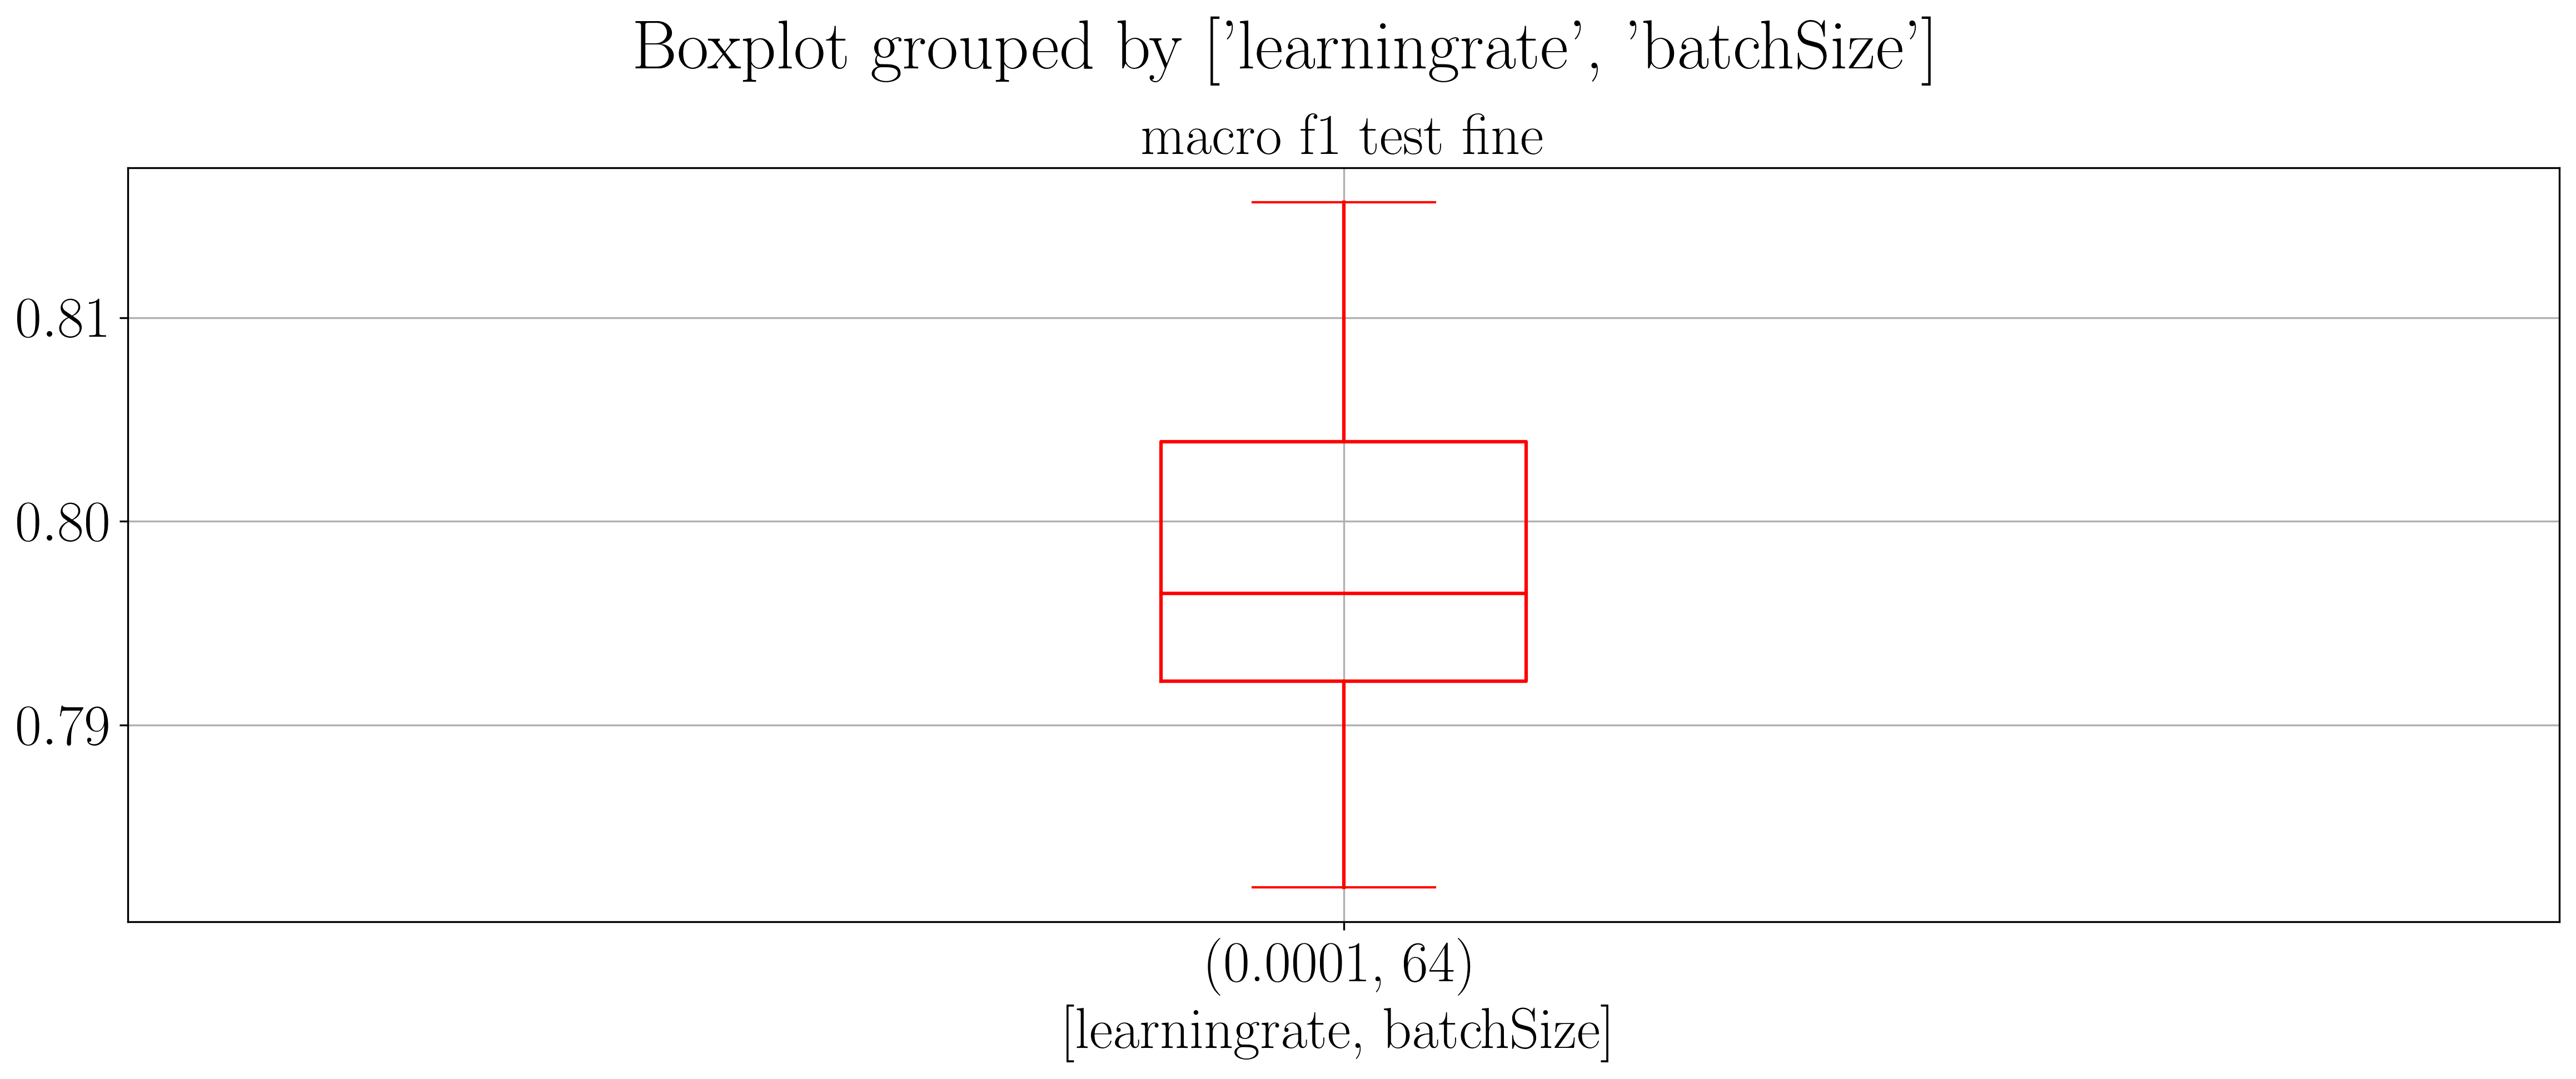

In [13]:
ts.pandasBoxplot(['macro f1 test fine'], ['learning_rate', 'batchSize'])

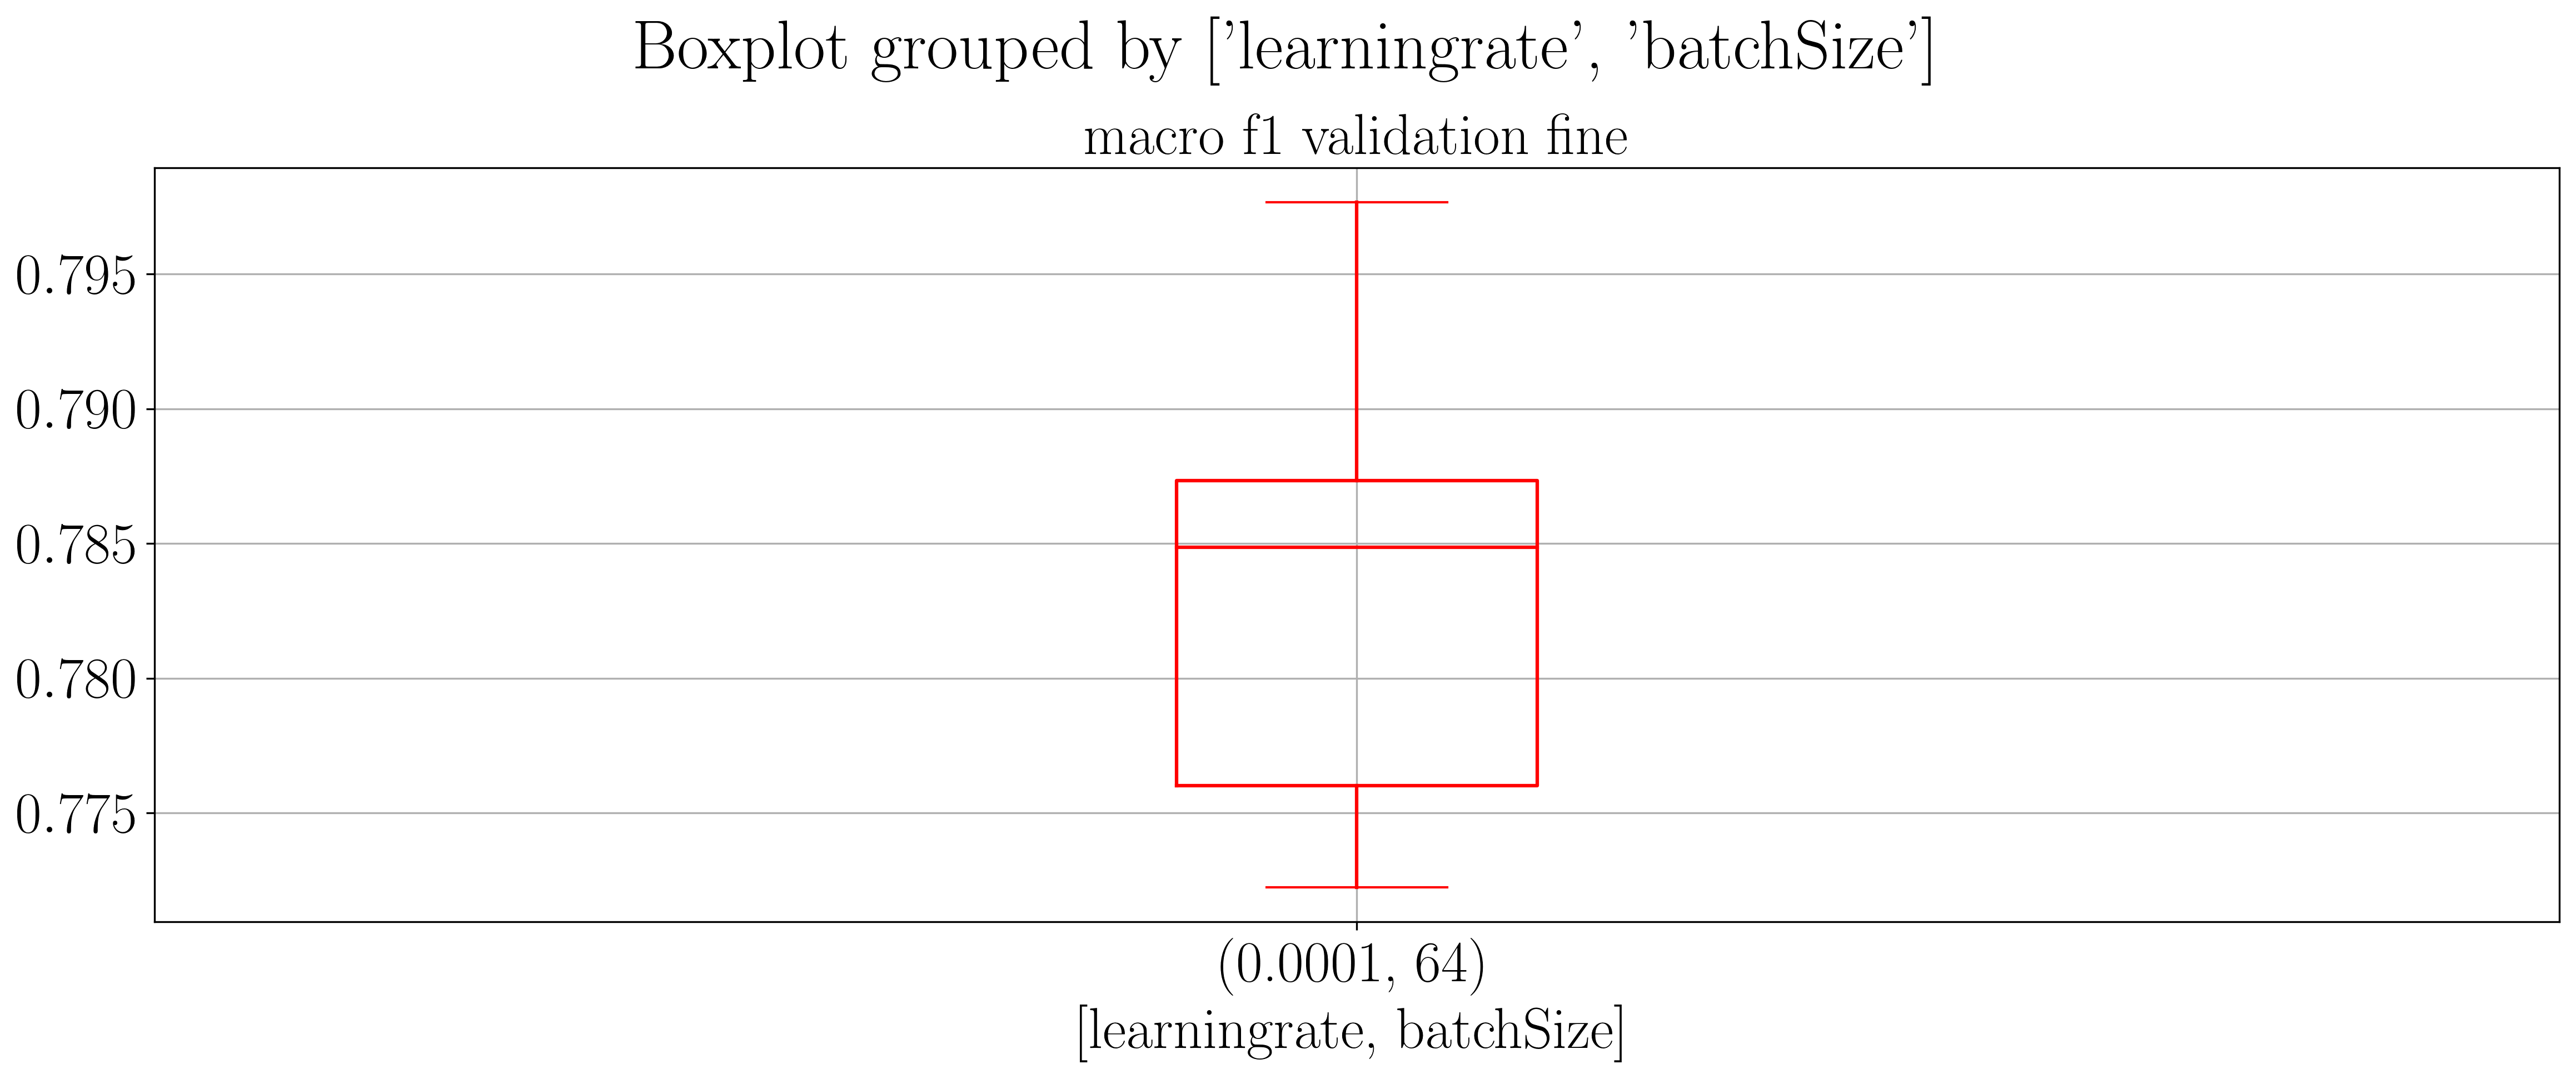

In [14]:
ts.pandasBoxplot(['macro f1 validation fine'], ['learning_rate', 'batchSize'])

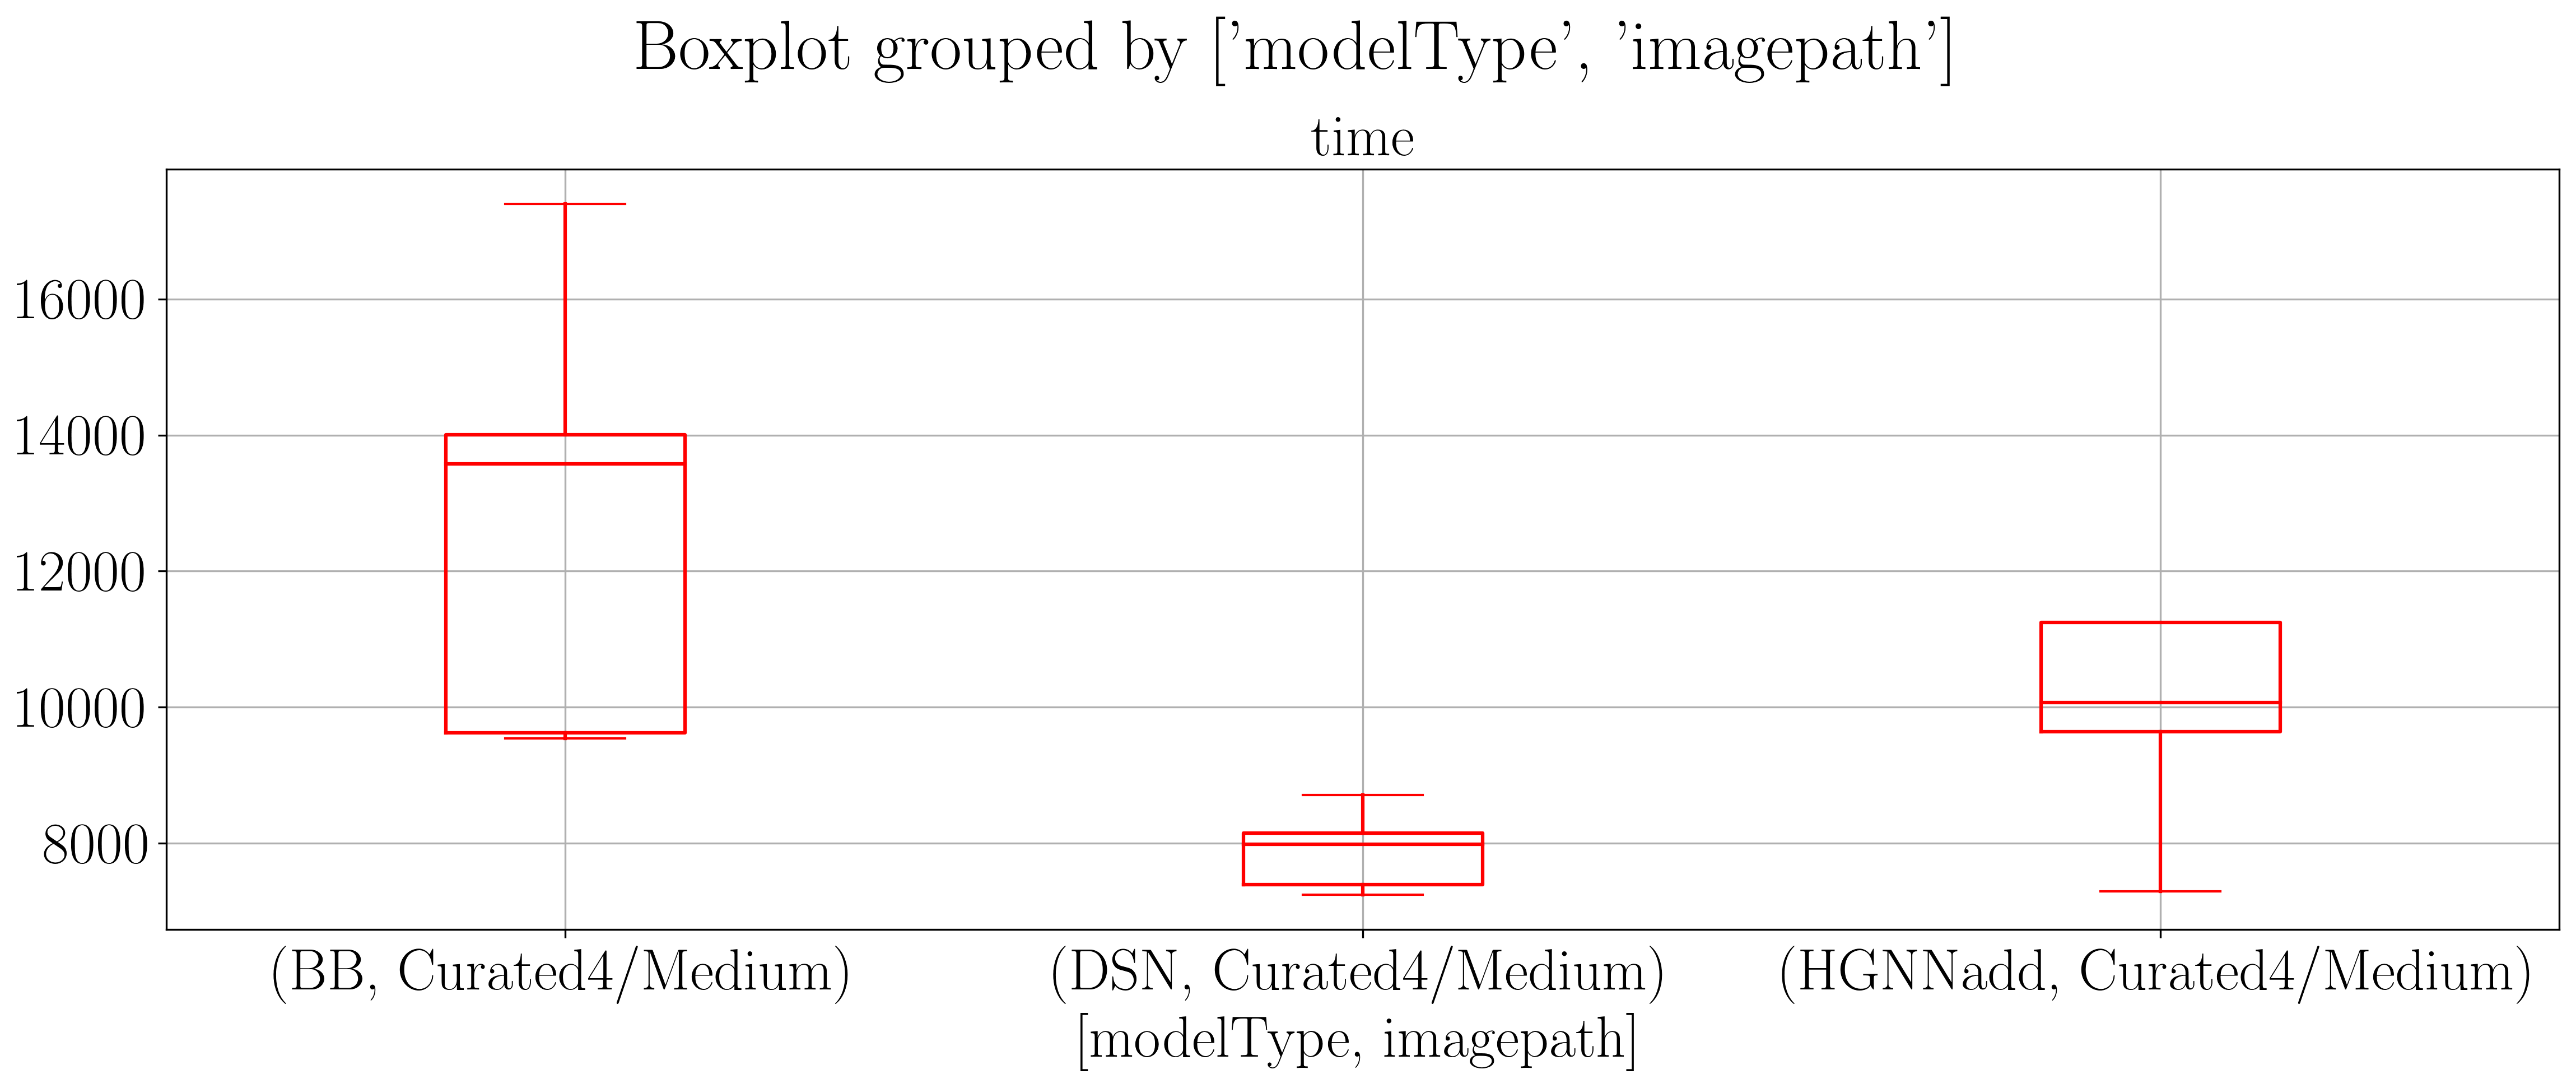

In [15]:
ts.pandasBoxplot(['time'], ['modelType', 'image_path'])

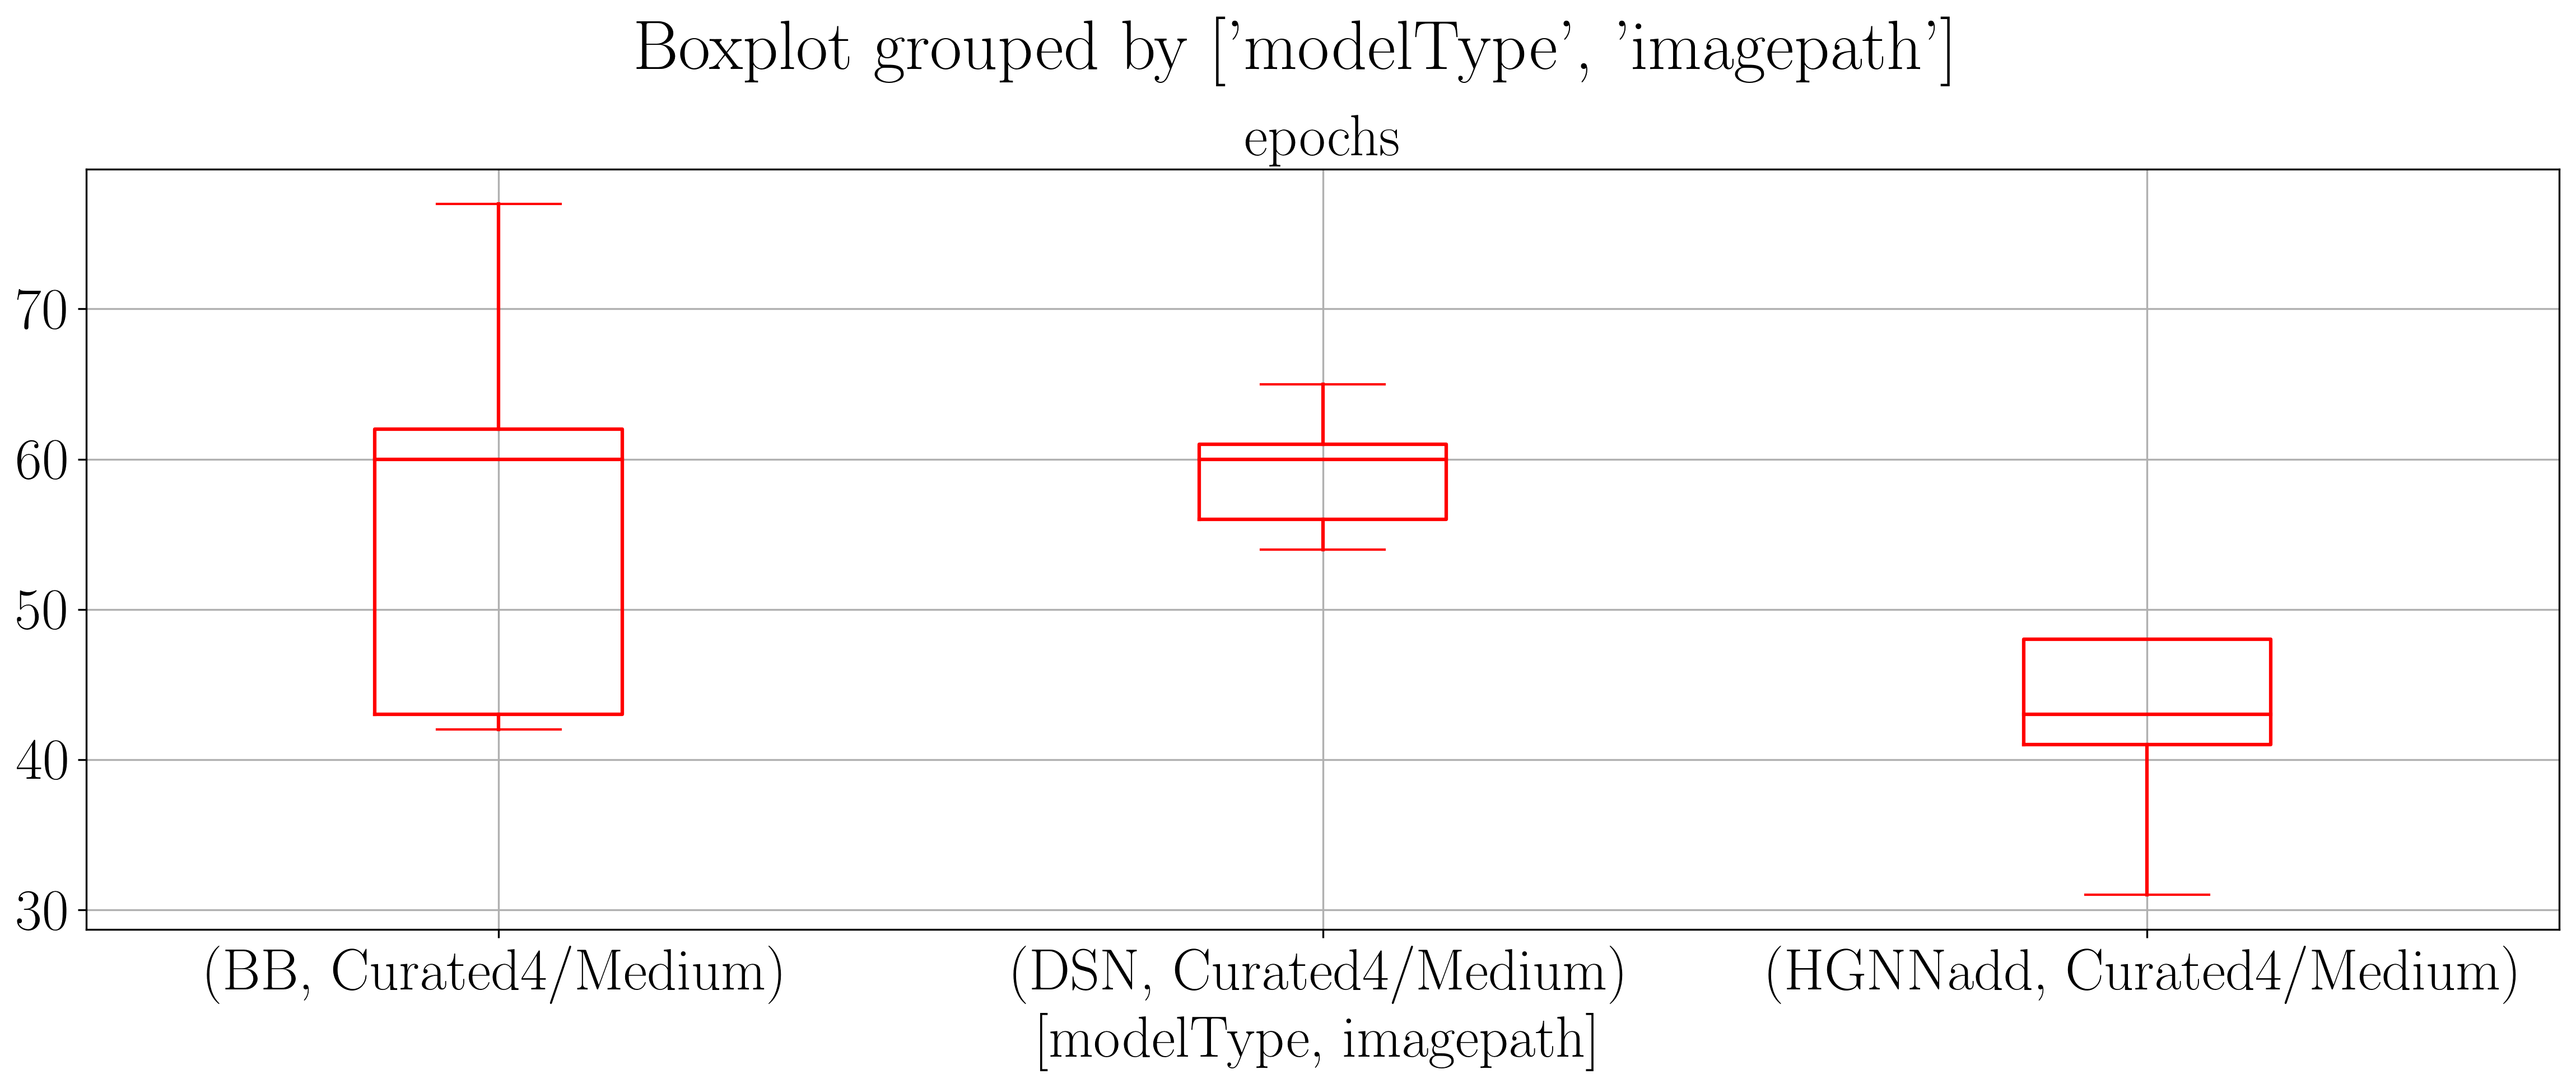

In [16]:
ts.pandasBoxplot(['epochs'], ['modelType', 'image_path'])